# Mount the Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import numpy as np
import os, sys

rbf_path = Path("/content/drive/MyDrive/Colab_Projects/RBF_NN_Talk/RBF-Network-Handwritten-Digits")
os.chdir(rbf_path)
sys.path.insert(0, str(rbf_path))

### This is a Nunpy based implemntation. We can do much better using GPU (Tensorflow/pytorch)

In [ ]:
import numpy as np
import time
import re
import sys
import math
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize, suppress=True)
np.random.seed(1)

### Read the inputs


*   For this demo, we will use the favorite **MNIST** dataset
*   60K Training and 10K test data


*   We normalize the training data (**WHY?**)

In [ ]:
def inputXFromFile(filename, sampleSize):  # SampleSize given for performace enhancement
    """Inputs the training examples X"""
    inputArray = np.zeros(shape=(sampleSize, 784))  # 784 = pixels of each image
    with open(filename, "r") as file:
        for i in range(sampleSize):
            inputList = []
            for _ in range(44):  # 44 lines of each example in file
                line = file.readline().strip("[").replace("]", "")
                inputList += line.split()
            inputArray[i] = inputList
    # print("X Input Size:", inputArray.shape)
    return np.divide(inputArray, 255)


def inputYFromFile(filename, sampleSize):
    """Inputs the training examples Y"""
    # for each row, we want a column like [0 0 1 0 ...]
    inputArray = np.zeros(shape=(sampleSize, 10))
    with open(filename, "r") as file:
        for i in range(sampleSize):
            value = file.readline()
            if not value:
                break
            inputArray[i][int(value)] = 1
    # print("Y input size:", inputArray.shape)
    return inputArray


### KMeans Clustering to find the center of each RBFNode

### We run KMeans for 15 rounds. Ideally, we may want to run until convergence

**Can you propose a measure of convergence?**

In [ ]:
def kMeansClustering(K, sampleData):
    """Find K cluster centeriods of the passed sampleData
    """
    # Randomly select K examples as starting point for centeriods
    randIndices = np.random.choice(sampleData.shape[0], size=K, replace=False)
    centeriods = sampleData[randIndices, :]

    dataSize = 10000
    data = sampleData[:dataSize]
    for i in range(15):
        centeriodSums = np.zeros(shape=centeriods.shape)
        centeriodSumsCounter = np.zeros(shape=K)

        # 1. Allocate a training example to its nearest centriod
        for x in data:
             # Get index of closest centeriod to X (minimum of ||C - X||)
            index = np.argmin(np.square(centeriods - x).sum(axis=1))
            centeriodSums[index] += x
            centeriodSumsCounter[index] += 1
        
        # 2. Reassign the centriods to new means
        for i in range(K):
            centeriods[i] = centeriodSums[i] / centeriodSumsCounter[i]
    
    return centeriods


### RBF Code

```
loadData: Loads the 60K samples

initializeCenters: Run KMeand and find the centers for each RBF Node
```

**Training**

```
1.   RBF Network is: ip --> 300 --> 10
2.   Initialize 300 centers
3.   Weight matrix is [300, 10]
4.   In this code, we use Gradient Descent with batchsize=1
```

**Finally, what should we save to perform inference?**

$W =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,10} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,10} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{300,1} & a_{300,2} & \cdots & a_{300,10}
 \end{pmatrix}$



$o_j(x) = \sum_{i=1}^{300} exp\big(\frac{-1}{\beta} ||x - c_i||^2\big) * W_{ji}$

$\mathcal{L}(o,y) = \frac{1}{2}(o-y)^2$

$\nabla \mathcal(\mathcal{L})_{W_{ji}} = (o-y) * exp\big(\frac{-1}{\beta} ||x - c_i||^2\big)$



In [ ]:
class Network:
    def __init__(self):
        self.XSize = 0
        self.HSize = 300
        self.OSize = 10
        self.X = []
        self.C = []
        self.Y = []
        self.W = []
        # self.B = np.random.uniform(-1, 1, (self.OSize))
        self.trainErrors = []
        self.testErrors = []

    def loadData(self, filenameX, filenameY, sampleSize):
        """Loads training/test data\n
        Parameters:\n
        - filenameX: filename for X features\n
        - filenameY: filename for Y (labels)\n
        - sampleSize: number of examples in dataset
        """
        self.X = inputXFromFile(filenameX, sampleSize)
        self.Y = inputYFromFile(filenameY, sampleSize)
        self.XSize = sampleSize

    def initializeCenters(self, K, useKMeans):
        """Initializes Centers (for RBF neurons in hidden layer)\n
        Parameters:\n
        - useKMeans: Set to true to use kMeans clustering to get centroids
        """
        print("Initialzing Centers...")
        self.HSize = K      # Since centriods is equal to hidden layer neurons
        if useKMeans:
            self.C = kMeansClustering(K, self.X)
        else:
            self.C = self.X[: self.HSize]

    def train(self, epochs=1, learnRate=0.5, K=300, useKMeans=False):
        """Trains the Network\n
        Parameters:\n
        - epochs: Number of epochs or trainings on entire dataset
        - learnRate: Learning Rate
        - K: Number of centers/centroids
        - useKMeans: Set to true to use kMeans clustering to get centroids
        """
        # Initialzing centers and weights
        self.initializeCenters(K, useKMeans)
        self.W = np.random.uniform(-1, 1, (self.HSize, self.OSize))

        self.trainErrors = np.zeros(shape=self.XSize)  # Preallocating numpy array
        print("Training...")
        for _ in range(epochs):
            # Take each data sample from the inputData
            for i, x in enumerate(self.X):
                HLayer = rbf(x, self.C)
                # Multiply the weights to get output for each data
                output = np.dot(HLayer, self.W)  # + self.B
                error = output - self.Y[i]
                self.W = self.W - (learnRate * np.outer(HLayer, error))
                # self.B = self.B - (learnRate * error)
                self.trainErrors[i] = 0.5 * sum(error ** 2)
        print("Training done")
        # Saving weights and centers in a file
        np.save("weights", self.W)
        np.save("centers", self.C)

    def predict(self):
        """Predicts using the Network by the set parameters (weight and
        centers) and displays the accuracy
        """
        self.testErrors = np.zeros(shape=self.XSize)  # Preallocating numpy array
        print("Prediciting...")
        totalAvg = count = correctCount = 0.0
        # Take each data sample from the inputData
        for count, x in enumerate(self.X):
            HLayer = rbf(x, self.C)
            output = np.dot(HLayer, self.W)  # + self.B
            o = np.argmax(output)
            y = np.argmax(self.Y[count])
            if o == y:
                correctCount += 1

            error = output - self.Y[count]
            self.testErrors[count] = 0.5 * sum(error ** 2)

        totalAvg = (correctCount * 100.0) / (count + 1)
        print(f"Total Avg. Accuracy: {totalAvg} %")


### RBF code

The RBF Node that we have chosen here is 

$rbf(x,c) = exp\big(\frac{-1}{\beta} ||x - c||^2\big)$

**Quick Question: Why is there a -ve sign inside the Exponential?**


In [ ]:
def rbf(x, C, beta=0.05):
    """Radial Basis Function\n
    Parameters:\n
    x: a training example
    C: centers of used for the hidden layer
    """
    H = np.zeros(shape=(np.shape(C)[0]))
    for i, c in enumerate(C):  # For each neuron in H layer
        H[i] = math.exp((-1 * beta) * np.dot(x - c, x - c))
    return H


### Learning Curve

We plot the training and test cost. 
For training, we average over every 100 rounds


In [ ]:
def plotLearningCurves(trainErrors, testErrors):
    """Plots the learning curves of both training cost and test cost
    """
    # Averaging over the first {avgSize} examples
    avgSize = 100
    if type(trainErrors) is np.ndarray:     # if trainError data is available
        Jtrain = trainErrors.reshape(-1, avgSize).mean(axis=1)
        plt.plot(Jtrain, label='Training Cost')
    Jtest = testErrors.reshape(-1, avgSize).mean(axis=1)
    plt.plot(Jtest, label='Test Cost')
    plt.xlabel(f"Data examples in {avgSize}s")
    plt.ylabel("Cost")
    plt.show()

1. Train the RBF Network
2. Predict using the RBF Network
Choose your option: 1
Importing data for training...
60000 training examples imported in 11.86 sec
Initialzing Centers...
Training...
Training done
Training took: 97.72 sec
1. Train the RBF Network
2. Predict using the RBF Network
Choose your option: 2
Enter file name containing weights (default: weights.npy): weights.npy
Importing data for testing...
Prediciting...
Total Avg. Accuracy: 90.07 %


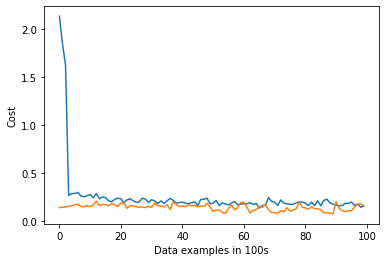

1. Train the RBF Network
2. Predict using the RBF Network
Choose your option: 3
Program exited.


In [ ]:
start = time.time()
trainDataSize = 60000
testDataSize = 10000

myNetwork = Network()
while True:
    print("1. Train the RBF Network\n2. Predict using the RBF Network")
    userInput = input("Choose your option: ")
    if userInput == "1":
        print("Importing data for training...")
        startTime = time.time()
        myNetwork.loadData("train.txt", "train-labels.txt", trainDataSize)
        print(
            f"{trainDataSize} training examples imported in {time.time()-startTime:.2f} sec"
        )
        
        startTrainingTime = time.time()
        myNetwork.train(epochs=1, learnRate=0.3, K=300, useKMeans=False)
        print(f"Training took: {time.time()-startTrainingTime:.2f} sec")
    elif userInput == "2":
        # Loading centers and weights from save file
        filename = input("Enter file name containing weights (default: weights.npy): ")
        myNetwork.W = np.load(filename)
        myNetwork.C = np.load("centers.npy")

        print("Importing data for testing...")
        myNetwork.loadData("test.txt", "test-labels.txt", testDataSize)
        myNetwork.predict()
        # Plotting the errors of the first 10000 examples
        plotLearningCurves(myNetwork.trainErrors[:10000], myNetwork.testErrors[:10000])
    else:
        break
print("Program exited.")
